## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [2]:
torch.cuda.is_available()

True

## Data

https://www.kaggle.com/datasets/paultimothymooney/stock-market-data

In [2]:
nasdaq = './stock_market_data/nasdaq/csv'

appl = os.path.join(nasdaq, 'AAPL.csv')
appl_df = pd.read_csv(appl)

appl_df

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492
...,...,...,...,...,...,...,...
10585,06-12-2022,141.919998,147.070007,64727200,147.300003,142.910004,142.910004
10586,07-12-2022,140.000000,142.190002,69721100,143.369995,140.940002,140.940002
10587,08-12-2022,141.100006,142.360001,62128300,143.520004,142.649994,142.649994
10588,09-12-2022,140.899994,142.339996,76069500,145.570007,142.160004,142.160004


In [3]:
appl_prices = appl_df.loc[:,'Close']
appl_prices

0          0.128348
1          0.121652
2          0.112723
3          0.115513
4          0.118862
            ...    
10585    142.910004
10586    140.940002
10587    142.649994
10588    142.160004
10589    142.320007
Name: Close, Length: 10590, dtype: float64

# Time2Vec

Vector embedding technique for time series data proposed in https://arxiv.org/abs/1907.05321

## Formulation

$$\textbf{t2v}(\tau)[0] = \omega_i\tau + \phi_i$$
$$\textbf{t2v}(\tau)[i] = F(\omega_i\tau + \phi_i)$$

where:
* $\textbf{t2v}(\tau)[i]$ is the $i^{th}$ element of $\textbf{t2v}(\tau)$
* F is a periodic activation (sine)
* $\omega_i$ and $\phi_i$ are learnable parameters (frequency and phase shift)

## Approach and Implementation

We can treat $\tau$ as 1 since our data is in days already we can assign the unit of the time series to also be 1 day. If our data was hourly, using $\tau = 24$ would allow us to also use 1 day units.

# Build Custom Dataset and Dataloaders

## Dataset

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

> A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

In [24]:
# Dataset of ALL stocks from a particular index (ex: NASDAQ)
class StockDataset(Dataset):
    def __init__(self, data_dir, nasdaq_100=False, close_only=True, as_tensor=True):
        self.data_dir = data_dir
        if nasdaq_100:
            with open('./stock_market_data/nasdaq100.json') as f:
                nasdaq100_json = json.load(f)

            nasdaq100_tickers = set([row['symbol'] + '.csv' for row in nasdaq100_json['data']['data']['rows']])
            self.paths = [ticker for ticker in set(os.listdir(self.data_dir)) & nasdaq100_tickers]
        else:
            self.paths = os.listdir(self.data_dir)
        self.close_only = close_only
        self.as_tensor = as_tensor
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        ticker_path = os.path.join(self.data_dir, self.paths[idx])
        data = pd.read_csv(ticker_path)
        if self.close_only:
            data = data.loc[:,'Close']
        if self.as_tensor:
            data = torch.tensor(data)
        return self.paths[idx].split('.')[0], data

## Dataloaders

There are plenty of stocks to choose from. We could use them all, but there is a great amount of variability in terms of volatility, relevance, volume, influence, etc. among the Nasdaq umbrella. Instead of using them all, we will be using the Nasdaq-100 index stocks for the preliminary investigation. This is not perfect but it works roughly well enough.

Nasdaq has an API which can be queried to get this list: https://api.nasdaq.com/api/quote/list-type/nasdaq100

In [26]:
nasdaq = './stock_market_data/nasdaq/csv'

NASDAQ = StockDataset(nasdaq, nasdaq_100=True)

# use batch size of 1 for now since each ticker has a different lifespan
dataloader = DataLoader(NASDAQ, batch_size=1, shuffle=False)

for ticker, close_prices in dataloader:
    print(ticker, close_prices.shape)

('ISRG',) torch.Size([1, 5659])
('LULU',) torch.Size([1, 3873])
('TXN',) torch.Size([1, 12744])
('MNST',) torch.Size([1, 9329])
('ADBE',) torch.Size([1, 9158])
('ODFL',) torch.Size([1, 7843])
('MSFT',) torch.Size([1, 9264])
('REGN',) torch.Size([1, 7987])
('MCHP',) torch.Size([1, 7489])
('SNPS',) torch.Size([1, 7758])
('AMGN',) torch.Size([1, 9955])
('ASML',) torch.Size([1, 6987])
('ENPH',) torch.Size([1, 2694])
('IDXX',) torch.Size([1, 7930])
('GILD',) torch.Size([1, 7782])
('FANG',) torch.Size([1, 2558])
('VRTX',) torch.Size([1, 7908])
('MAR',) torch.Size([1, 6224])
('SBUX',) torch.Size([1, 7673])
('BIIB',) torch.Size([1, 7870])
('CSGP',) torch.Size([1, 6154])
('ON',) torch.Size([1, 5691])
('ORLY',) torch.Size([1, 7465])
('NFLX',) torch.Size([1, 5176])
('INTC',) torch.Size([1, 10778])
('PCAR',) torch.Size([1, 10778])
('CMCSA',) torch.Size([1, 10778])
('CTAS',) torch.Size([1, 9911])
('ALGN',) torch.Size([1, 5503])
('CSCO',) torch.Size([1, 8269])
('CPRT',) torch.Size([1, 7237])
('FAST'

In [ ]:
NASDAQ = StockDataset(nasdaq, nasdaq_100=True, masked=True)

# use batch size of 1 for now since each ticker has a different lifespan
dataloader = DataLoader(NASDAQ, batch_size=1, shuffle=False)

for ticker, close_prices in dataloader:
    print(ticker, close_prices.shape)

## Data Issues

**LRCX.csv**: Expected 7 fields in line 4926, saw 9

# Learning the Embeddings

https://towardsdatascience.com/random-initialization-for-neural-networks-a-thing-of-the-past-bfcdd806bf9e#:~:text=This%20serves%20the%20process%20of,longer%20performing%20the%20same%20computation.

tensor([1.2081, 0.2465, 0.6017, 0.1546, 1.0000, 0.1235, 0.8593, 0.4848, 0.3872,
        0.7683, 0.2937, 0.7315, 0.9842, 0.4494, 0.4922, 0.9989, 0.9905, 0.9129,
        0.9469, 0.4615, 0.9091, 0.6771, 0.9916, 0.6790, 0.8387, 0.8285, 0.6569,
        0.0504, 0.3405, 0.1141, 0.8953, 0.9936, 0.9999, 0.6835, 0.3046, 0.6538,
        0.9154, 0.4832, 0.4339, 0.6013, 0.8221, 0.9348, 0.7930, 0.0806, 0.2774,
        0.4350, 0.7804, 0.9999, 0.4741, 0.9430, 0.2615, 0.8054, 0.7754, 0.1808,
        0.1522, 0.7429, 0.1995, 0.8468, 0.4854, 0.8724, 0.9989, 0.7524, 0.9926,
        0.4642, 0.9837, 0.4355, 0.9751, 0.9936, 0.3568, 0.6072, 0.7306, 0.6727,
        0.7788, 0.6217, 0.6301, 0.5723, 0.8378, 0.6122, 0.5952, 0.1592, 0.9905,
        0.8824, 0.8105, 1.0000, 0.9824, 0.3798, 0.7640, 0.9959, 0.2436, 0.0038,
        0.9690, 0.5576, 0.8640, 0.8438, 0.9705, 0.6421, 0.0522, 0.8497, 0.9688,
        0.5723, 0.7798])

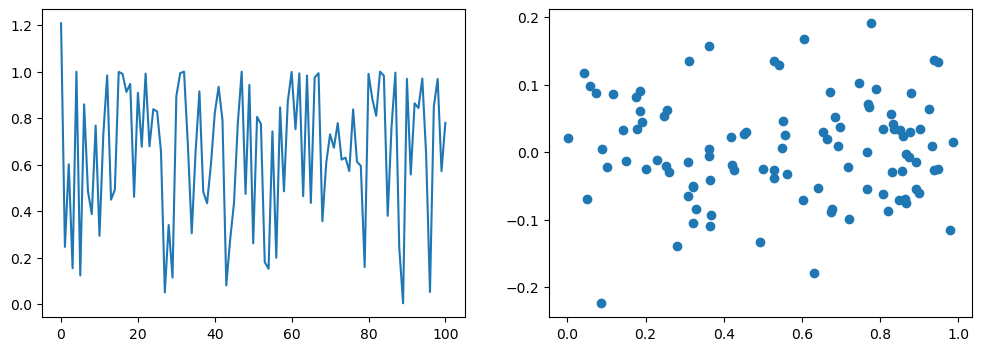

In [75]:
L = 500
k = 100
tau = 1

# initialize embedding parameters (he-et-al)
omega = np.random.random(k+1)
phi = np.random.random(k+1)*2*np.pi%omega
w = np.random.randn(k+1)*np.sqrt(2/L)

# initialize
t2v = torch.zeros(k+1)
t2v[0] = omega[0]*tau + phi[0]
for i in range(1,k+1):
    t2v[i] = np.sin(omega[i]*tau + phi[i])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(t2v)
axs[1].scatter(omega, w)
t2v

# Stocks as a Signal

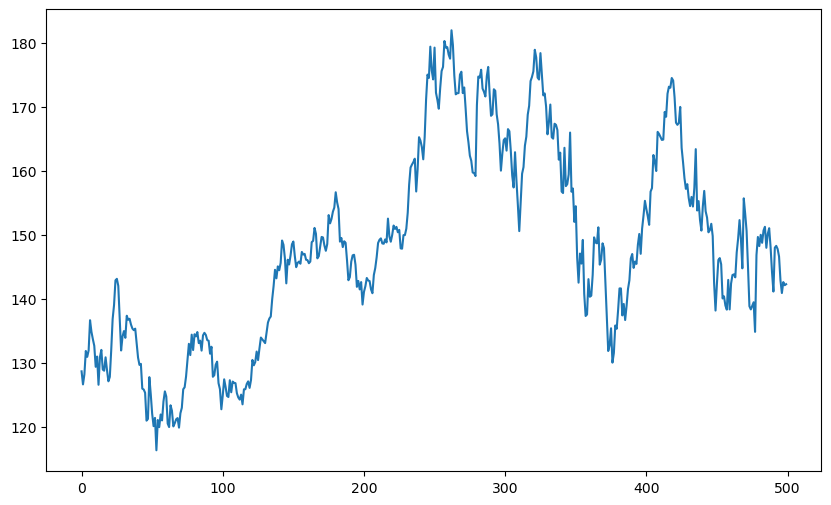

In [8]:
data = appl_prices[-500:].reset_index(drop=True)
data

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data)

## Training the Embedding

We can use the masked language modeling task, adapted to this time series to obfuscate regions of the graph and predict using the surrounding information. For example, predicting the red regions of the graph below and adjusting our embeddings.

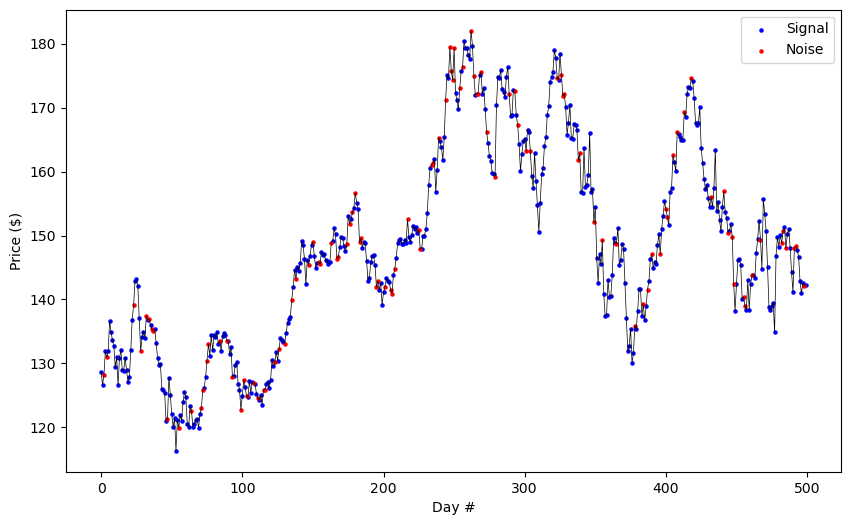

In [9]:
from matplotlib import colors

noise = sorted(np.r_[np.random.randint(len(data), size=len(data)//4)])
noisy_data = data.loc[noise]
noise = noisy_data.index.unique()
noisy_data = data.loc[noise]
clean = data.index.difference(noise)
clean_data = data.loc[clean]

masked_df = pd.concat([
    pd.DataFrame(np.stack([noisy_data, np.ones(len(noisy_data))]).T, columns=['data', 'masked'], index=noise), 
    pd.DataFrame(np.stack([clean_data, np.zeros(len(clean_data))]).T, columns=['data', 'masked'], index=clean)
]).astype({'masked': 'int'}).sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(masked_df['data'], c='k', lw=0.5)
ax.scatter(clean, clean_data, c='b', s=5, label='Signal')
ax.scatter(noise, noisy_data, c='r', s=5, label='Noise')
ax.set_xlabel('Day #')
ax.set_ylabel('Price ($)')
ax.legend()
plt.show()

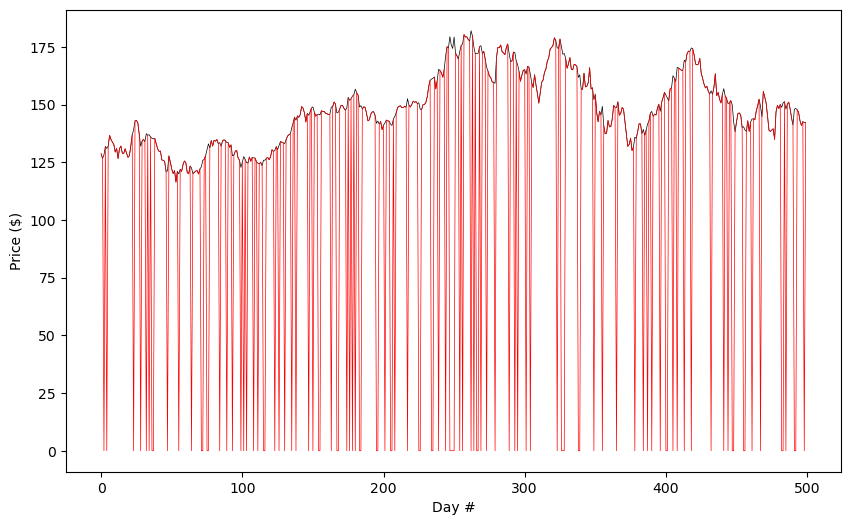

In [10]:
corrupted = np.zeros(len(noise))

corrupted_data = masked_df.apply(lambda x: x[0] if x[1] == 0 else 0, axis=1)
corrupted_df = masked_df.copy()
corrupted_df.loc[:,'data'] = corrupted_data

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(masked_df['data'], c='k', lw=0.5)
ax.plot(corrupted_df['data'], c='r', lw=0.5)
ax.set_xlabel('Day #')
ax.set_ylabel('Price ($)')
plt.show()

In [4]:
def convert_signal(signal):
    if torch.is_tensor(signal):
        signal = signal.numpy()
    else:
        signal = signal.to_numpy()
    signal = signal*255//max(signal)
    signal = signal
    signal = np.tile(signal, (len(signal)//5, 1))
    return signal

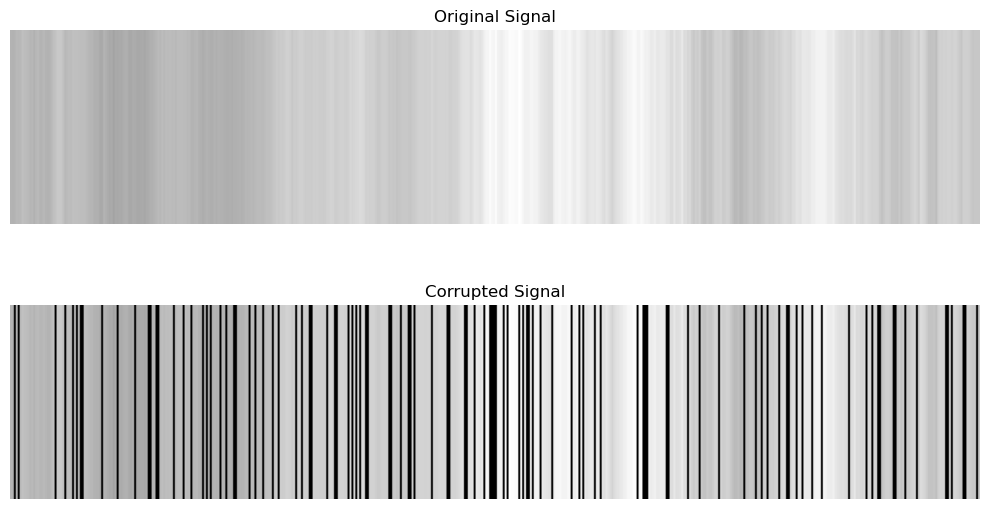

In [140]:
# signal = masked_df['data'].to_numpy()
# signal = signal*255//max(signal)
# signal = signal
# signal = np.tile(signal, (len(signal)//5, 1))

# corrupted = corrupted_df['data'].to_numpy()
# corrupted = corrupted*255//max(corrupted)
# corrupted = corrupted
# corrupted = np.tile(corrupted, (len(corrupted)//5, 1))

signal, corrupted = convert_signal(masked_df['data']), convert_signal(corrupted_df['data'])

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].imshow(signal, cmap='gray', vmin=0, vmax=255)
axs[1].imshow(corrupted, cmap='gray', vmin=0, vmax=255)
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[0].set_title('Original Signal')
axs[1].set_title('Corrupted Signal')
plt.tight_layout()

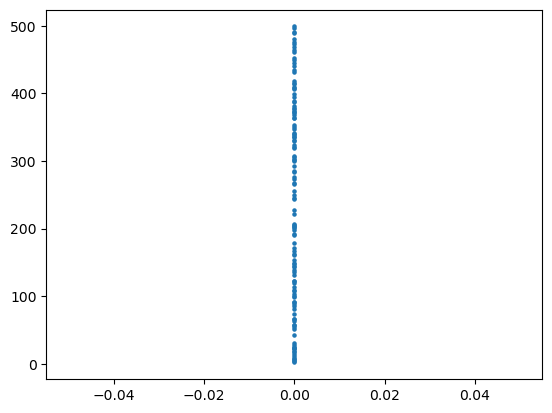

In [40]:
mask_ratio = 0.25
# new way of generating randoms with np
rng = np.random.default_rng()
corruption_idx = rng.choice(masked_df.index, size=int(len(masked_df)*mask_ratio), replace=False)

# corruption_idx = torch.multinomial(torch.tensor(masked_df.index, dtype=torch.float), len(masked_df)//4, replacement=False)
plt.scatter(torch.zeros(len(corruption_idx)), corruption_idx, s=5)

## Create a Dataset to Mask a Signal

In [10]:
class MaskedTickerDataset(Dataset):
    def __init__(self, ticker_path, mask_ratio=0.25, window_size=90, stride=45, close_only=True, as_tensor=True):
        self.ticker_path = ticker_path
        self.mask_ratio = mask_ratio
        self.window_size = window_size
        self.stride = stride
        self.close_only = close_only
        self.as_tensor = as_tensor
        
        data = pd.read_csv(self.ticker_path)
        if self.close_only:
            data = data.loc[:,'Close']
        if self.as_tensor:
            data = torch.tensor(data, dtype=torch.float32)
        self.data = data
        
        self.rng = np.random.default_rng()
        
        self.mask = np.r_[self.rng.choice(range(len(self.data)), size=int(len(self.data)*self.mask_ratio), replace=False)]
        
    def __len__(self):
        return len(self.data)//self.stride - 1
    
    def __getitem__(self, idx):
        idx = self.stride*idx
        # hacky way to throw an index error
        self.data[idx+self.window_size-1]
        y = self.data[idx:idx+self.window_size]
        x = y.clone()
        mask = [i-idx for i in filter(lambda i: i >= idx and i < idx+self.window_size, self.mask)]
        x[mask] = 0
        return (x, y)

### Visualize the Masking Process

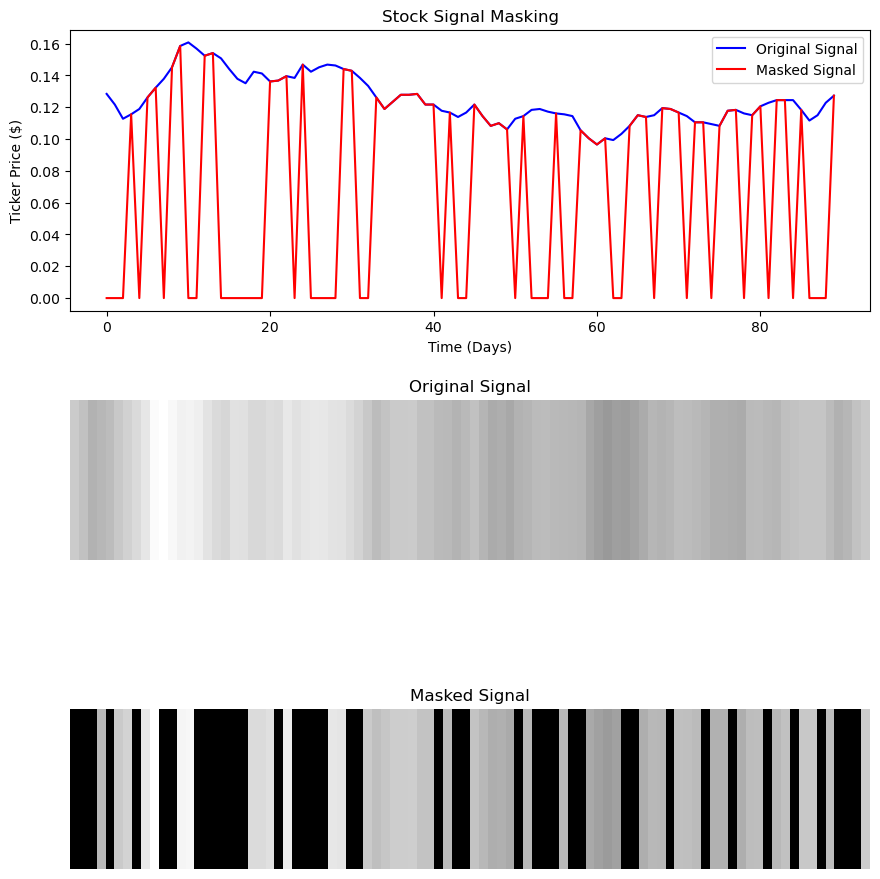

In [11]:
nasdaq = './stock_market_data/nasdaq/csv'
appl = os.path.join(nasdaq, 'AAPL.csv')

MaskedAppleDataset = MaskedTickerDataset(appl, mask_ratio=0.4)
for x, y in MaskedAppleDataset:
    break

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
# graph
axs[0].plot(y, c='b', label='Original Signal')
axs[0].plot(x, c='r', label='Masked Signal')
axs[0].set_xlabel('Time (Days)')
axs[0].set_ylabel('Ticker Price ($)')
axs[0].set_title('Stock Signal Masking')
axs[0].legend()
# bars
axs[1].imshow(convert_signal(y), cmap='gray', vmin=0, vmax=255)
axs[2].imshow(convert_signal(x), cmap='gray', vmin=0, vmax=255)
axs[1].set_axis_off()
axs[2].set_axis_off()
axs[1].set_title('Original Signal')
axs[2].set_title('Masked Signal')
plt.subplots_adjust(left=0.1,
                    bottom=0.05,
                    right=0.9,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.1)
plt.show()

## Create a DataLoader for the Dataset

## Training

https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html

In [12]:
class SignalAutoencoder(nn.Module):
    def __init__(self):
        super(SignalAutoencoder, self).__init__()
        input_size=90
        bottleneck_size=15
        
        self.input_size = input_size
        self.hidden_sizes = [45, 30]
        self.bottleneck_size = bottleneck_size
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_sizes[0]),
            nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1]),
            nn.Linear(self.hidden_sizes[1], self.bottleneck_size)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.bottleneck_size, self.hidden_sizes[1]),
            nn.Linear(self.hidden_sizes[1], self.hidden_sizes[0]),
            nn.Linear(self.hidden_sizes[0], self.input_size)
        )
        
        
        self.norms = [nn.InstanceNorm1d(hs) for hs in self.hidden_sizes]
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        
        return dec

**UNet** converts signals to spectrograms with the MelSpectrogram and uses a convolutional denoising autoencoder on the spectrograms

In [15]:
dataloader = DataLoader(MaskedAppleDataset, batch_size=1, shuffle=True)
AE = SignalAutoencoder()

n_epochs = 200
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(AE.parameters())

In [17]:
# training loop
AE.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, y in dataloader:
        out = AE(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'epoch {epoch+1} loss: {epoch_loss / len(dataloader)}')

epoch 1 loss: 218.61345217277048
epoch 2 loss: 54.011880352360826
epoch 3 loss: 60.23432406836038
epoch 4 loss: 121.01035046686904
epoch 5 loss: 78.93123848439377
epoch 6 loss: 66.64096231202986
epoch 7 loss: 94.54954645168992
epoch 8 loss: 98.5923875115183
epoch 9 loss: 36.4816937845471
epoch 10 loss: 169.84813104752197
epoch 11 loss: 35.41487665070046
epoch 12 loss: 19.973765154934338
epoch 13 loss: 15.349816715376626
epoch 14 loss: 23.5650250675698
epoch 15 loss: 36.273752995456256
epoch 16 loss: 38.00915648101264
epoch 17 loss: 74.82948043042968
epoch 18 loss: 114.74827604536684
epoch 19 loss: 43.516917643169116
epoch 20 loss: 143.8714362332661
epoch 21 loss: 121.73214336568648
epoch 22 loss: 45.26262657306133
epoch 23 loss: 42.088081230879084
epoch 24 loss: 20.758652806393485
epoch 25 loss: 28.92029740406264
epoch 26 loss: 20.372655126899
epoch 27 loss: 65.91042676120678
epoch 28 loss: 47.81725918417239
epoch 29 loss: 54.872264543022865
epoch 30 loss: 54.23093455587713
epoch 31 lo

## Model Inference

torch.Size([90])


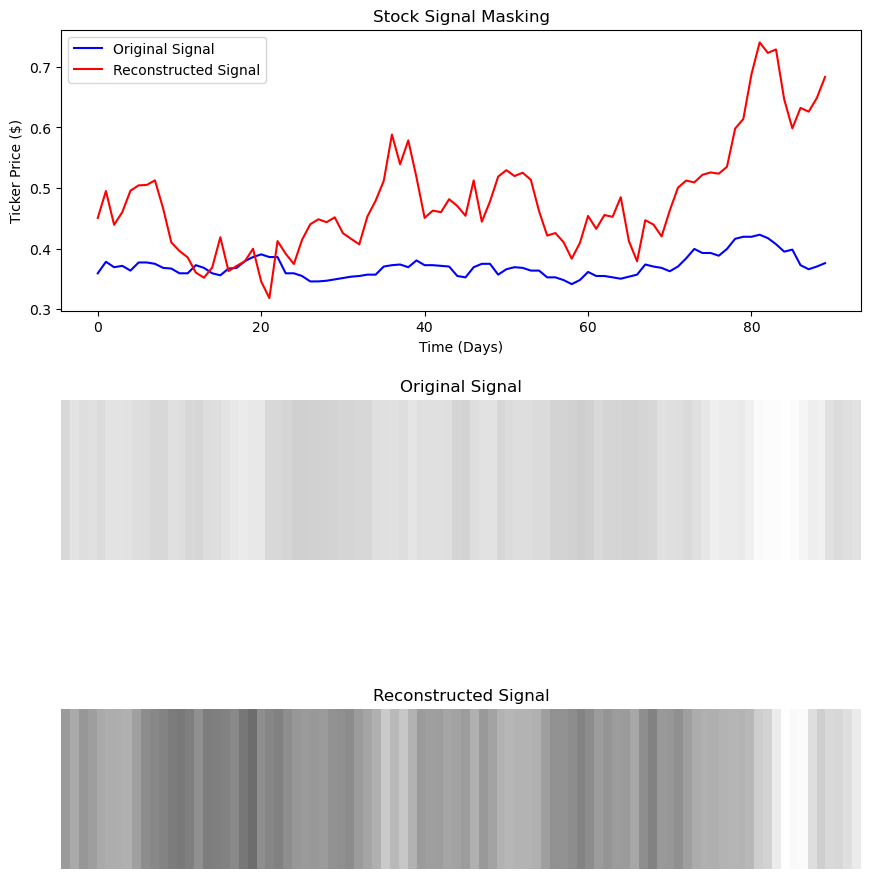

In [18]:
AE.eval()
for x, y in dataloader:
    out = AE(x).detach()
    break

out, y = out.reshape(-1), y.reshape(-1)
print(y.shape)
    
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
# graph
axs[0].plot(y, c='b', label='Original Signal')
axs[0].plot(out, c='r', label='Reconstructed Signal')
axs[0].set_xlabel('Time (Days)')
axs[0].set_ylabel('Ticker Price ($)')
axs[0].set_title('Stock Signal Masking')
axs[0].legend()
# bars
axs[1].imshow(convert_signal(y), cmap='gray', vmin=0, vmax=255)
axs[2].imshow(convert_signal(out), cmap='gray', vmin=0, vmax=255)
axs[1].set_axis_off()
axs[2].set_axis_off()
axs[1].set_title('Original Signal')
axs[2].set_title('Reconstructed Signal')
plt.subplots_adjust(left=0.1,
                    bottom=0.05,
                    right=0.9,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.1)
plt.show()

### Entire Signal Reconstruction

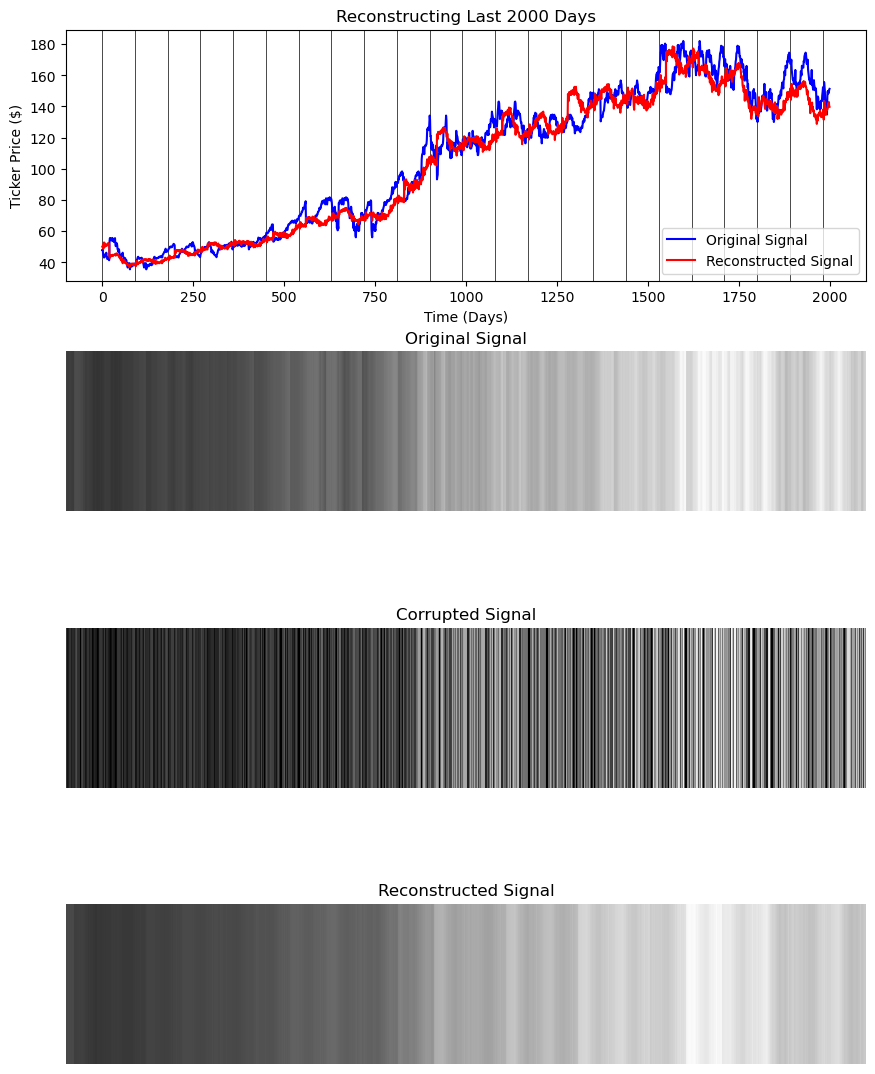

In [20]:
signals = []
corruptions = []
reconstructions = []

# new loader with shuffling off for a continuous signal
testloader = DataLoader(MaskedAppleDataset, batch_size=1)

AE.eval()
for x, y in testloader:
    signals.append(y.reshape(-1))
    corruptions.append(x.reshape(-1))
    reconstructions.append(AE(x).detach().reshape(-1))

signal = torch.concat(signals)
corruption = torch.concat(corruptions)
reconstruction = torch.concat(reconstructions)

fig, axs = plt.subplots(4, 1, figsize=(10, 12))
# graph
n_days = 2000
for i in range(n_days//90 + 1):
    axs[0].axvline(x=i*90, c='k', lw=0.5)
axs[0].plot(signal[-n_days:], c='b', label='Original Signal')
axs[0].plot(reconstruction[-n_days:], c='r', label='Reconstructed Signal')
axs[0].set_xlabel('Time (Days)')
axs[0].set_ylabel('Ticker Price ($)')
axs[0].set_title(f'Reconstructing Last {n_days} Days')
axs[0].legend()
# bars
axs[1].imshow(convert_signal(signal[-n_days:]), cmap='gray', vmin=0, vmax=255)
axs[1].set_axis_off()
axs[1].set_title('Original Signal')
axs[2].imshow(convert_signal(corruption[-n_days:]), cmap='gray', vmin=0, vmax=255)
axs[2].set_axis_off()
axs[2].set_title('Corrupted Signal')
axs[3].imshow(convert_signal(reconstruction[-n_days:]), cmap='gray', vmin=0, vmax=255)
axs[3].set_axis_off()
axs[3].set_title('Reconstructed Signal')
plt.subplots_adjust(left=0.1,
                    bottom=0.05,
                    right=0.9,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.1)
plt.show()

## Predicting Ahead

We now wish to take our bottleneck representations (latent weights) and predict strictly forward. For example we would like to predict 1 week or 1 month ahead and see how well the model does at predicting an upward or downward trend, and more specifically the actual values of the upcoming time period.

In [ ]:
class StockOutpainting(nn.Module):
    def __init__(self, lookahead=7):
        self.lookahead = lookahead
    
    def forward(self, x):
        

In [77]:
class t2vModel(nn.Module):
    def __init__(self, activation=torch.sin, k=100):
        super().__init__()
        self.activation = activation
        self.k = k
        self.hidden_size = 50
        
        self.w = torch.nn.Parameter(torch.randn(()))
        self.phi = torch.nn.Parameter(torch.randn(()))
        self.fc = torch.nn.Linear(self.hidden_size, 1)
    
    def forward(self, x):
        tau = x
        v = torch.matmul(tau, self.w) + self.phi
        v[1:] = self.activation(v[1:])
        
        out = self.fc(v)
        return out

model = t2vModel()
model

t2vModel(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## Perform Time Series Decomposition

https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html

In [5]:
class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0)
    
    def forward(self, x):
        # pad the left and right side s.t. the MA has the same length as the input
        # [a b c d e f] -> [x a b c d e f x] for kernel_sizes = 3, 4
        pad_size = (self.kernel_size-1) // 2
        front = x[:, 0:1].repeat(1, pad_size)
        end = x[:, -1:].repeat(1, pad_size)
        
        x_pad = torch.cat([front, x, end], dim=1)
        
        x_t = self.avg(x_pad)
        x_s = x - x_t
        
        return x_s, x_t

In [6]:
appl_tensor = torch.tensor(appl_prices).reshape(1, -1)

decomp = DecompositionLayer(365)
x_s, x_t = decomp(appl_tensor)
x_s, x_t

(tensor([[ 3.3818e-03, -3.2149e-03, -1.2041e-02,  ..., -4.9487e+00,
          -5.3755e+00, -5.1429e+00]], dtype=torch.float64),
 tensor([[1.2497e-01, 1.2487e-01, 1.2476e-01,  ..., 1.4760e+02, 1.4754e+02,
          1.4746e+02]], dtype=torch.float64))

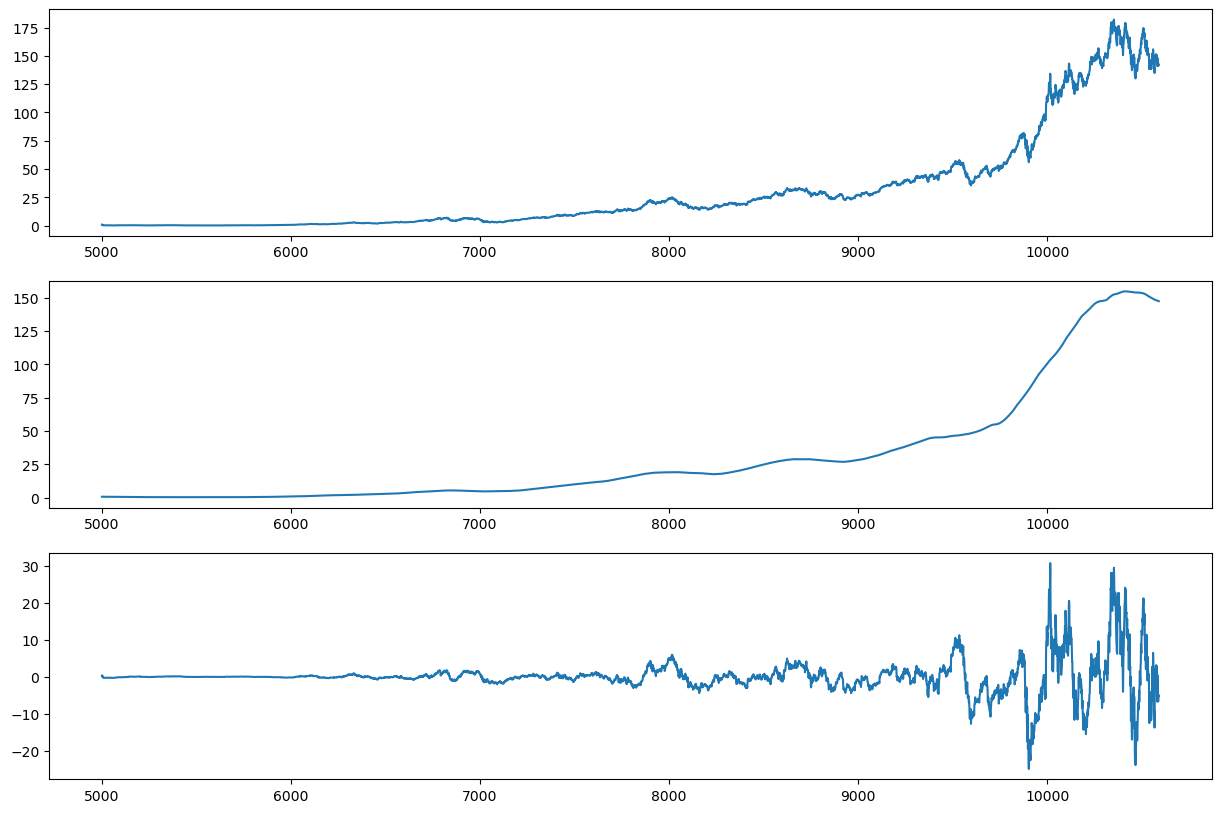

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(15,10))
axs[0].plot(appl_df.index[5000:], appl_tensor.reshape(-1)[5000:])
axs[1].plot(appl_df.index[5000:], x_t.reshape(-1)[5000:])
axs[2].plot(appl_df.index[5000:], x_s.reshape(-1)[5000:])

https://pytorch.org/docs/stable/generated/torch.fft.rfft.html

torch.Size([1, 10590])
tensor([[1.0000, 0.9992, 0.9983,  ..., 0.9975, 0.9983, 0.9992]],
       dtype=torch.float64)


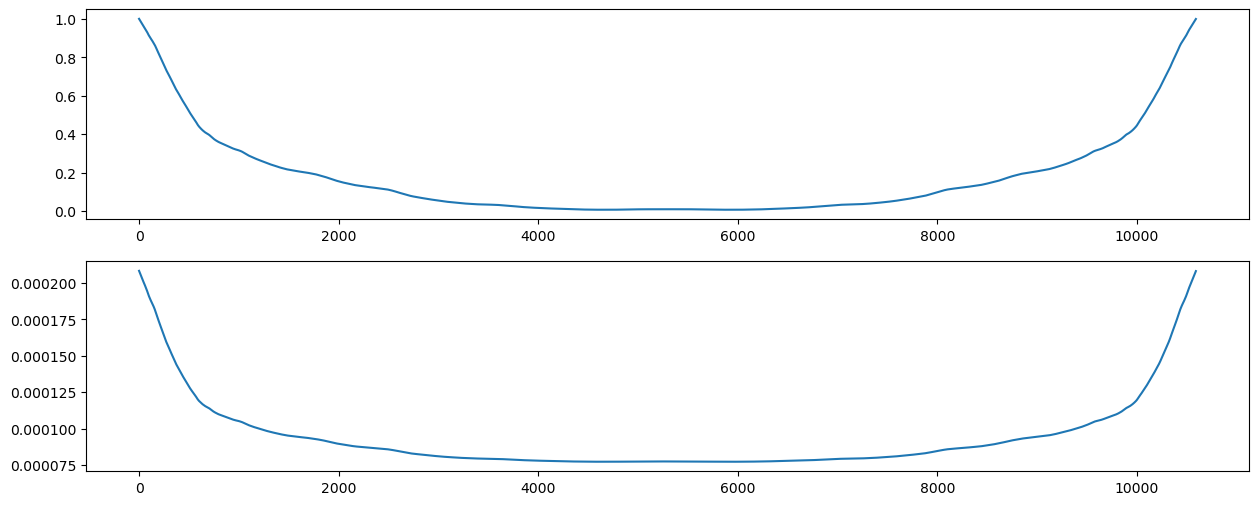

In [9]:
def autocorrelation(query_states, key_states):
    """
    Computes autocorrelation(Q,K) using `torch.fft`. 
    Think about it as a replacement for the QK^T in the self-attention.
    
    Assumption: states are resized to same shape of [batch_size, time_length, embedding_dim].
    """
    query_states_fft = torch.fft.rfft(query_states, dim=1)
    key_states_fft = torch.fft.rfft(key_states, dim=1)
    attn_weights = query_states_fft * torch.conj(key_states_fft)
    attn_weights = torch.fft.irfft(attn_weights, dim=1)  
    
    return attn_weights

R = autocorrelation(appl_tensor, appl_tensor)
print(R.shape)
R = R / max(R[0])
print(R)
R_hat = nn.functional.softmax(R - max(R[0]), dim=1)
R, R_hat
# R[0,0], R[0,-1], R_hat[0,0], R_hat[0,-1]
# plt.plot(AC.reshape(-1))

fig, axs = plt.subplots(2, 1, figsize=(15,6))
axs[0].plot(R.reshape(-1))
axs[1].plot(R_hat.reshape(-1))

In [53]:
torch.mean(R, dim=0)

tensor([15743339.6163, 15730042.1619, 15717134.5943,  ...,
        15704321.9608, 15717134.5943, 15730042.1619], dtype=torch.float64)

Autocorrelation-Attention

1. Select the top-k time lags according to some autocorrelation factor which influences the value of k

2. Compute the rolled value of the tensor at each time lag in the top-k time lags
https://pytorch.org/docs/stable/generated/torch.roll.html

3. Compute the softmax of the autocorrelation at each time lag in the top-k time lags

4. Dot the results of steps 2 and 3

5. Sum the result of steps 2-4 for all top-k

tensor([15743339.6163, 15730042.1619, 15730042.1619, 15717134.5943,
        15717134.5943, 15704321.9608, 15704321.9608, 15691931.9270,
        15691931.9270, 15679205.2522, 15679205.2522, 15665616.0708,
        15665616.0708, 15652048.1971, 15652048.1971, 15638237.7227,
        15638237.7227, 15624964.7259], dtype=torch.float64) tensor([    0,     1, 10589,     2, 10588,     3, 10587,     4, 10586, 10585,
            5,     6, 10584,     7, 10583,     8, 10582,     9])


tensor([[1.8116e+10, 1.5786e+10, 1.3466e+10,  ..., 2.4927e+10, 2.2662e+10,
         2.0443e+10]])

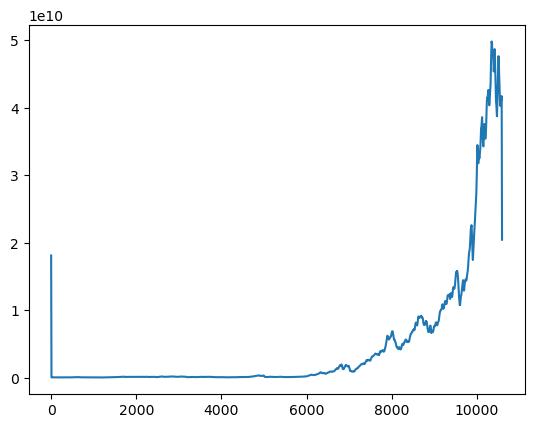

In [46]:
import math

R = autocorrelation(appl_tensor, appl_tensor)

L = appl_tensor.size(1)
AC_factor = 2
k = int(AC_factor*math.log(L))

L, k

R_mean = torch.mean(R, dim=0)
topk_R, topk_tau = torch.topk(R_mean, k, dim=0)
# topk_R = topk_R / max(topk_R[0])
print(topk_R, topk_tau)

topk_R_hat = nn.functional.softmax(topk_R - max(topk_R), dim=0)

agg = torch.zeros_like(appl_tensor).float()
for i in range(k):
    rolled = appl_tensor.roll(shifts=-int(topk_tau[i]), dims=1)
#     print(rolled, topk_R[i])
    agg += rolled * topk_R[i]

attn_output = agg.contiguous()
plt.plot(attn_output.reshape(-1))
attn_output
